# Implementación demodulador BFSK no coherente

In [93]:
import matplotlib.pyplot as plt
import numpy as np

Generamos un array con los coeficientes de un periodo de cada una de las dos señales senoidales a frecuencias distintas y con una frecuencia de muestreo determinada. Usamos senoidales de amplitud unidad.

In [94]:
fs = 44100 # Frecuencia de muestreo estándar
frec0 = 5000 # Frecuencia de la senoidal para el cero
frec1 = 10000 # Frecuencia de la senoidal para el uno

# Obtenemos los instantes en los que se debe evaluar el seno a cada frecuencia
t0 = np.arange(0, 1/frec0, 1/fs)
t1 = np.arange(0, 1/frec1, 1/fs)

signal0 = np.sin(2*np.pi*frec0*t0)
signal1 = np.sin(2*np.pi*frec1*t1)

Se representan las muestras almacenadas de las señales.

<StemContainer object of 3 artists>

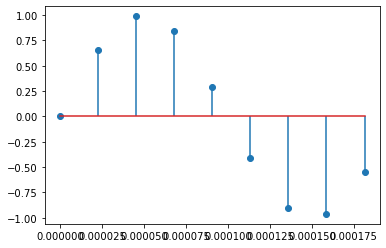

In [95]:
plt.stem(t0,signal0,use_line_collection=True)

<StemContainer object of 3 artists>

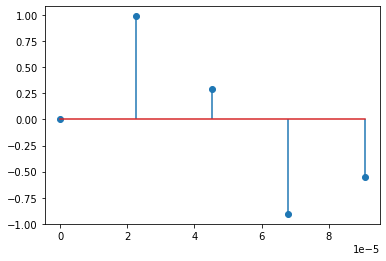

In [96]:
plt.stem(t1,signal1,use_line_collection=True)

Utilizamos una señal de prueba a la entrada del demodulador, compuesta por la concatenación de varios periodos de cada una de las señales.

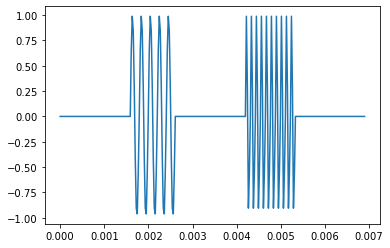

In [97]:
inputSignal = np.concatenate((np.zeros(70),np.tile(signal0,5),np.zeros(70),np.tile(signal1,10),np.zeros(70)))
inputTime = np.arange(0, np.size(inputSignal)/fs, 1/fs)

plt.plot(inputTime,inputSignal)

Diseñamos un filtro FIR con frecuencia central frec0 y otro con frecuencia central frec1. El ancho de banda de los filtros es de 1 kHz, y la caída configurada en el software de diseño de filtros es también de 3 kHz. Usamos a priori una ventana rectangular porque es la que necesita menos coeficientes y el filtro será más rápido. Es muy importante que los filtros tengan el mismo número de coeficientes para que la velocidad sea la misma.

In [102]:
# Coeficientes del filtro con frecuencia central 5 kHz y ancho de banda 2 kHz
h0 = [
    -0.000174996249436762,
    -0.000653668881823510,
    -0.000620461281331986,
    0.000631143813800533,
    0.002801307162251474,
    0.004129808556945606,
    0.001851933312672135,
    0.023918781810949835,
    -0.038283655348746615,
    -0.106939581934703404,
    -0.128703637613183125,
    -0.071936097359141110,
    0.045658465432387038,
    0.162622039110268013,
    0.211397238938176357,
    0.162622039110269290,
    0.045658465432387010,
    -0.071936097359141138,
    -0.128703637613183097,
    -0.106939581934703876,
    -0.038283655348746601,
    0.023918781810949731,
    0.001851933312672192,
    0.004129808556945698,
    0.002801307162251540,
    0.000631143813800538,
    -0.000620461281332006,
    -0.000653668881823524,
    -0.000174996249436756,
]

# Coeficientes del filtro con frecuencia central 10 kHz y ancho de banda 2 kHz
h1 = [
    0.001171781962095800,
    0.002523300136144947,
    -0.002035054842247541,
    -0.006748394484964242,
    0.001101155293253838,
    0.012122839804154677,
    0.000475738045390574,
    -0.054040835092397883,
    -0.064052886183204649,
    0.084249735066660447,
    0.122061817455254698,
    -0.073787396626608659,
    -0.169567254750159463,
    0.041353288725045803,
    0.210344330983156080,
    0.041353288725046122,
    -0.169567254750160601,
    -0.073787396626608465,
    0.122061817455254656,
    0.084249735066660794,
    -0.064052886183204663,
    -0.054040835092397696,
    0.000475738045390602,
    0.012122839804154684,
    0.001101155293253807,
    -0.006748394484964257,
    -0.002035054842247567,
    0.002523300136144955,
    0.001171781962095795,
]

Creamos una clase para un filtro FIR que tendrá los métodos apropiados para manejar una lista circular (buffer circular). Para la implementación en C será necesaria una función init que inicialize las variables del filtro.

In [103]:
class FIR_Filter:
    def __init__(self, coefs):
        self.h = coefs # Coeficientes del filtro
        
        # Atributos asociados al buffer circular
        self.buf = [0]*len(self.h)
        self.bufIndex = 0 
        
        # Salida actual del filtro
        self.out = 0
    
    def FIRFilterClear(self):
        self.buf = [0]*len(self.h)
        self.bufIndex = 0
        self.out = 0
    
    def FIRFilterUpdate(self, filterInput):
        
        # Metemos la última muestra en el buffer circular
        self.buf[self.bufIndex] = filterInput
        
        # Incrementamos el índice
        self.bufIndex += 1
        
        if self.bufIndex == len(self.buf):
            self.bufIndex = 0
        
        # Computamos el nuevo valor de la salida
        self.out = 0
        
        sumIndex = self.bufIndex
        
        for n in range(len(self.buf)):
            if sumIndex > 0:
                sumIndex -= 1
            else:
                sumIndex = len(self.buf)-1
                
            self.out += self.h[n]*self.buf[sumIndex]

Creamos un objeto por cada filtro e introducimos la señal de prueba, representando la salida de cada filtro y la señal original.

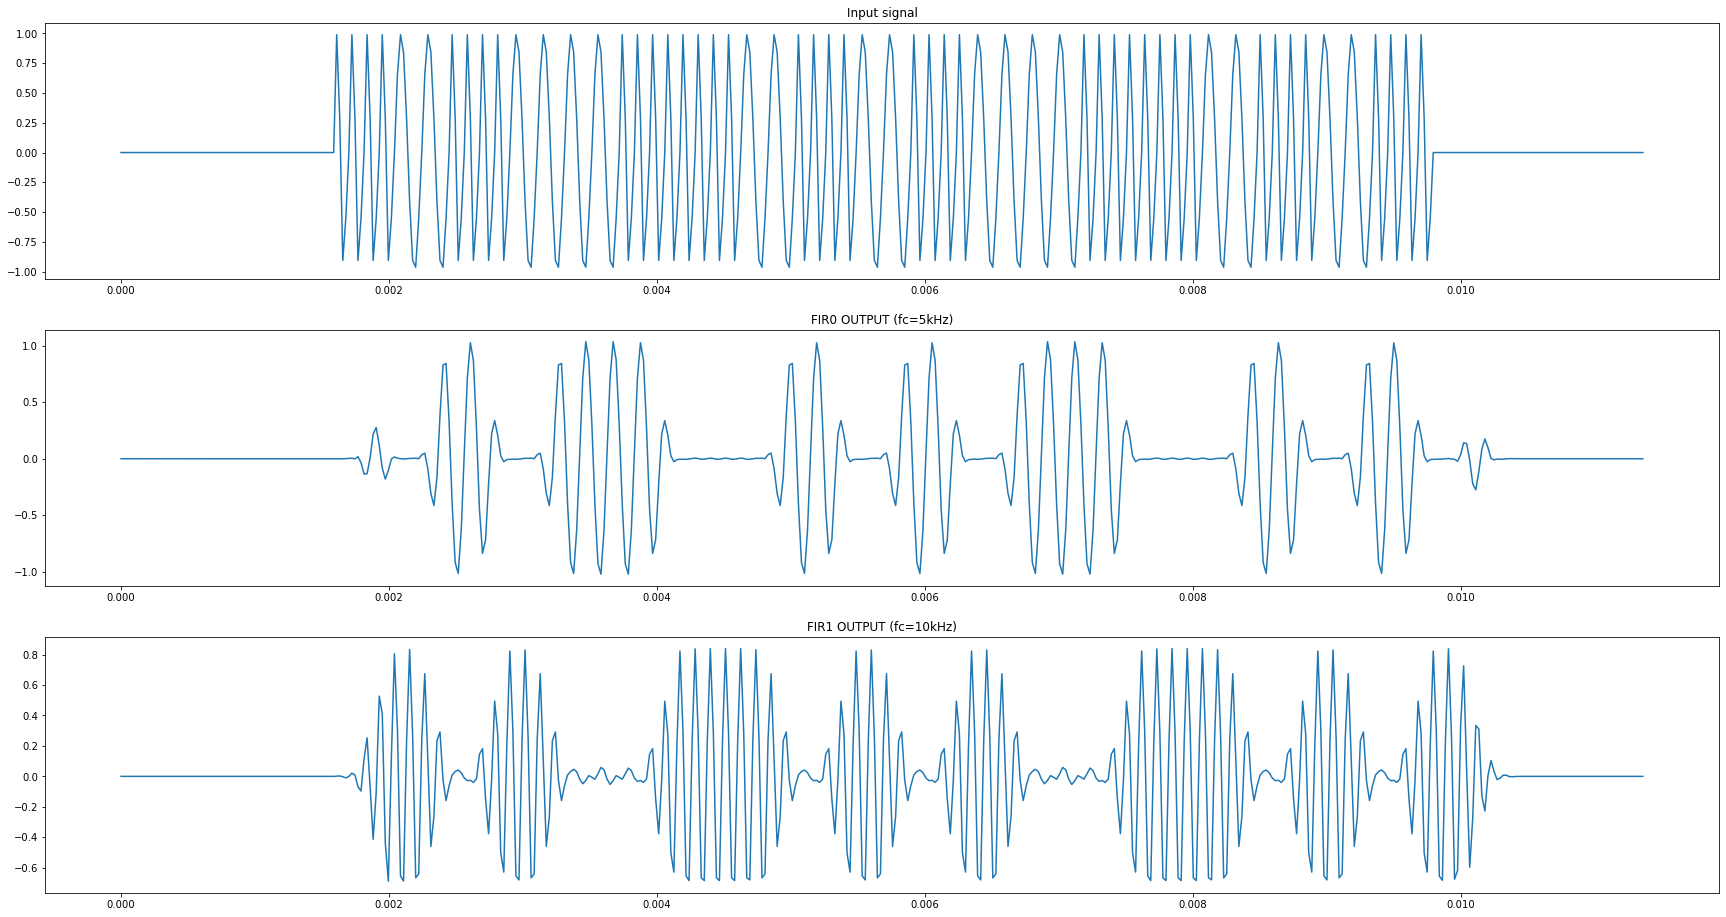

In [104]:
fir0 = FIR_Filter(h0)
fir1 = FIR_Filter(h1)

salida_fir0 = np.array([])
salida_fir1 = np.array([])

for sample in inputSignal:
    # Actualizamos el valor de los dos filtros
    fir0.FIRFilterUpdate(sample)
    fir1.FIRFilterUpdate(sample)
    
    salida_fir0 = np.append(salida_fir0,fir0.out)
    salida_fir1 = np.append(salida_fir1,fir1.out)

fig, axes = plt.subplots(3,1,figsize=(30,16))
axes[0].set_title("Input signal")
axes[0].plot(inputTime,inputSignal)
axes[1].set_title("FIR0 OUTPUT (fc=5kHz)")
axes[1].plot(inputTime,salida_fir0)
axes[2].set_title("FIR1 OUTPUT (fc=10kHz)")
axes[2].plot(inputTime,salida_fir1)

Ahora probamos con un paquete de capa física formado por un bit de stop, un bit de start, 8 bits de datos y un bit de paridad par.

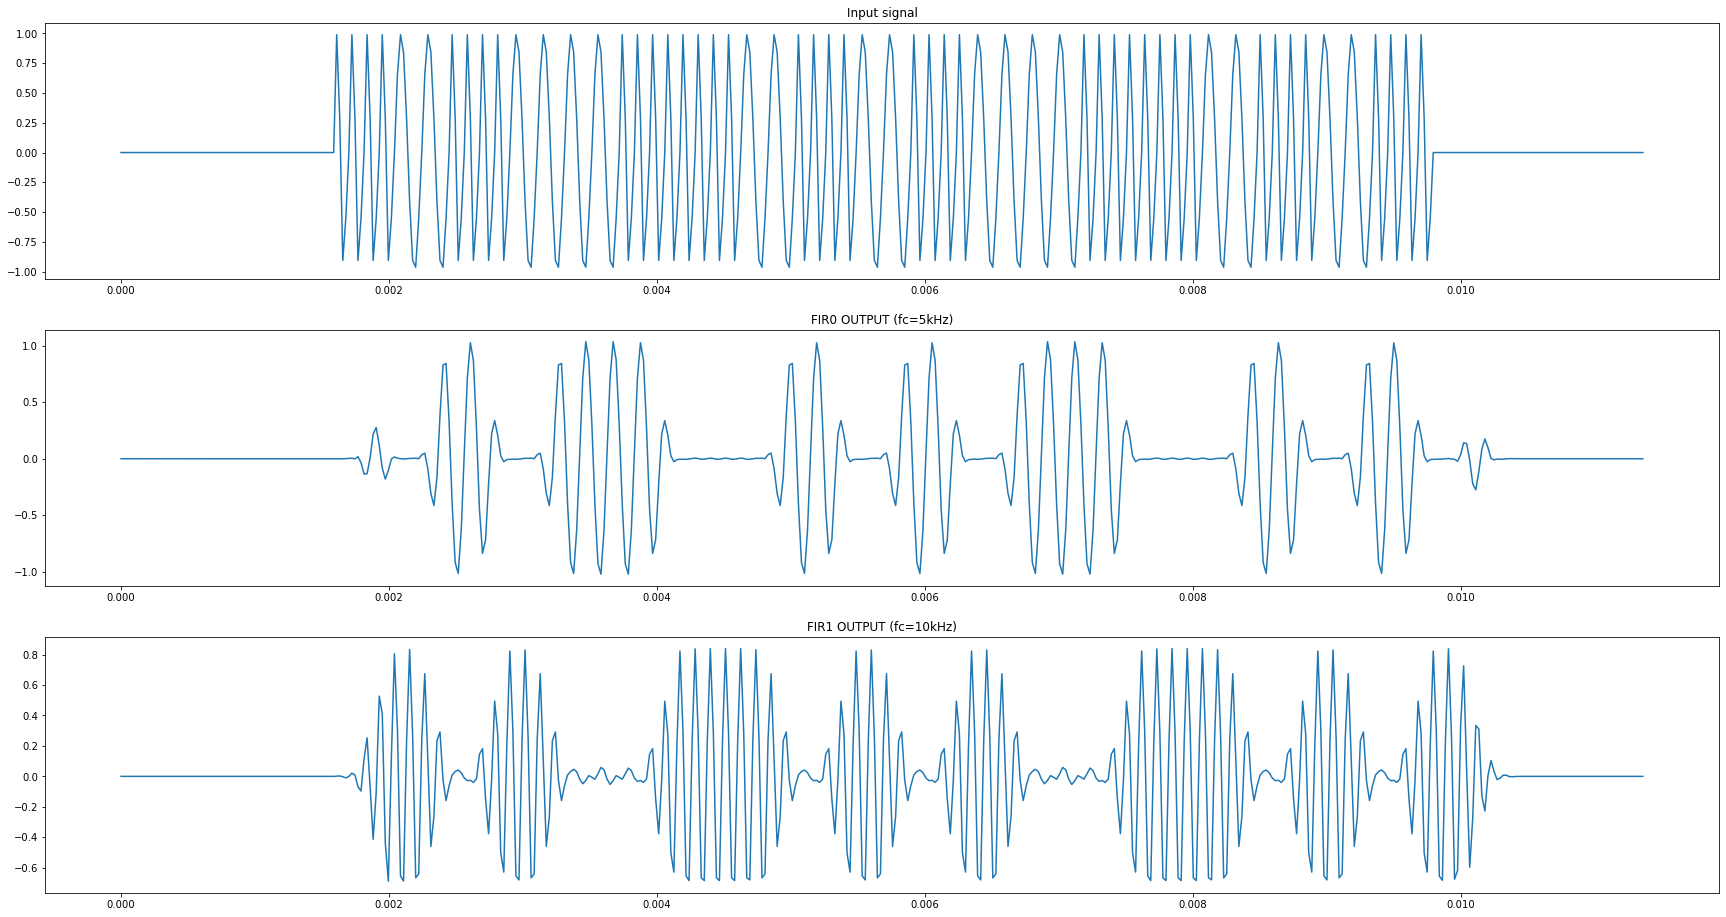

In [105]:
inputSignal = np.concatenate((np.zeros(70),
                              np.tile(signal1,4), # BIT STOP
                              np.tile(signal0,2), # BIT START
                              np.tile(signal1,4), # COMIENZO DATOS
                              np.tile(signal0,2),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal1,4), # BIT PARIDAD (PAR),
                              np.zeros(70)
                             ))
inputTime = np.arange(0, np.size(inputSignal)/fs, 1/fs)

# Reiniciamos los filtros
fir0.FIRFilterClear()
fir1.FIRFilterClear()

salida_fir0 = np.array([])
salida_fir1 = np.array([])

for sample in inputSignal:
    # Actualizamos el valor de los dos filtros
    fir0.FIRFilterUpdate(sample)
    fir1.FIRFilterUpdate(sample)
    
    salida_fir0 = np.append(salida_fir0,fir0.out)
    salida_fir1 = np.append(salida_fir1,fir1.out)

fig, axes = plt.subplots(3,1,figsize=(30,16))
axes[0].set_title("Input signal")
axes[0].plot(inputTime,inputSignal)
axes[1].set_title("FIR0 OUTPUT (fc=5kHz)")
axes[1].plot(inputTime,salida_fir0)
axes[2].set_title("FIR1 OUTPUT (fc=10kHz)")
axes[2].plot(inputTime,salida_fir1)